<a href="https://colab.research.google.com/github/VikrantVDeo/Vibration-Analysis/blob/main/Room_175.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas matplotlib seaborn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [ ]:
sns.set(style="whitegrid")

In [1]:
files = {
    "175n": "169_run32_in_175n.txt",
    "175m": "169_run33_in_175m.txt",
    "175S": "169_run34_in_175S.txt",
    "175Son":  "169_run35_in_175Son.txt",

}


In [4]:
def read_velocity_file(file_path):
    with open(file_path, 'r') as f:
        lines = [line for line in f if line.strip()]
    for idx, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) >= 2:
            try:
                float(parts[0])
                float(parts[1])
                data_start = idx
                break
            except:
                continue
    else:
        return None
    df = pd.read_csv(file_path, skiprows=data_start, sep=r'\s+', names=["Hz", "in/s"])
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    return df


In [7]:
# Build merged DataFrame
merged_df = None
for label, fname in files.items():
    path = Path("/content") / fname
    df = read_velocity_file(path)
    if df is not None:
        df = df.set_index("Hz").rename(columns={"in/s": label})
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.join(df, how="outer")

Merged DataFrame created


,Hz,175n,175m,175S,175Son
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.5,2.727665e-05,2.959346e-05,2.449566e-05,2.652887e-05
2,1.0,5.059779e-07,5.397179e-07,4.704304e-07,5.137021e-07
3,1.5,2.312501e-07,2.552553e-07,2.426018e-07,2.304915e-07
4,2.0,1.644698e-07,1.429519e-07,1.656466e-07,1.591856e-07


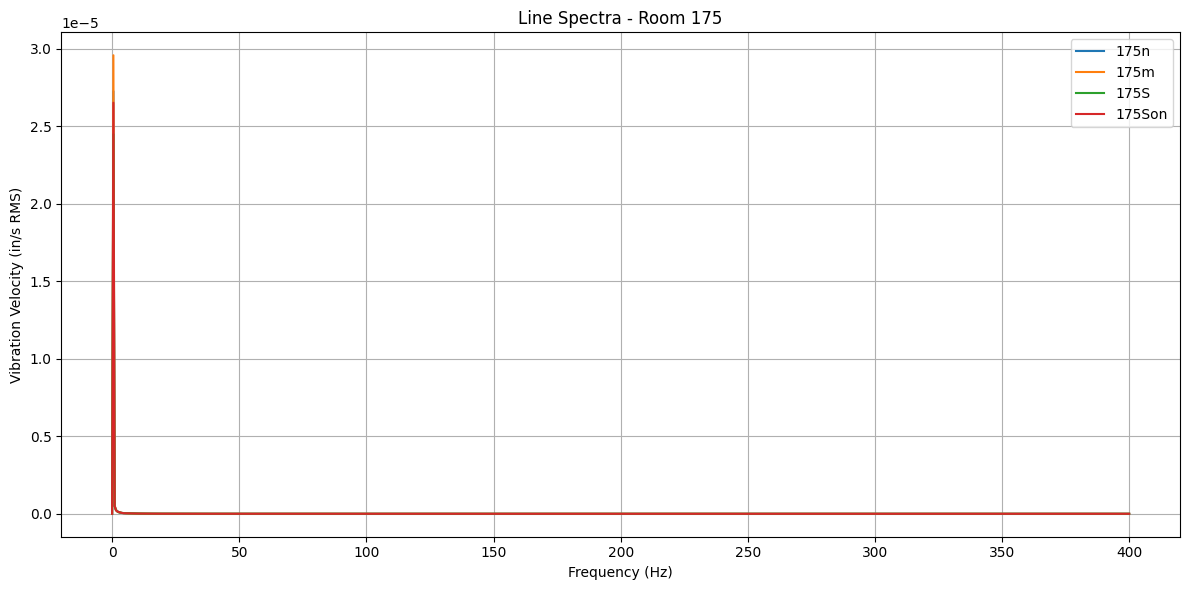

In [8]:
# Reset index to include Hz as a column
merged_df.reset_index(inplace=True)
print("Merged DataFrame created")
display(merged_df.head())

# LINE SPECTRA PLOT
plt.figure(figsize=(12, 6))
for label in files.keys():
    plt.plot(merged_df["Hz"], merged_df[label], label=label)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Vibration Velocity (in/s RMS)")
plt.title("Line Spectra - Room 175")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


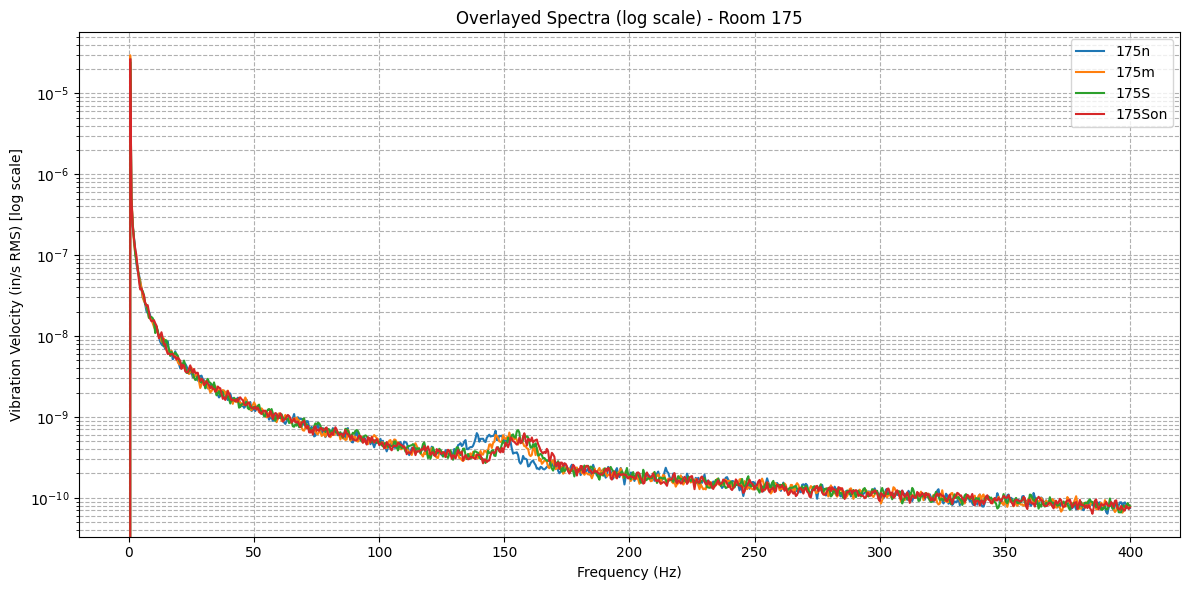

In [9]:
# OVERLAYED SPECTRA (LOG SCALE)
plt.figure(figsize=(12, 6))
for label in files.keys():
    plt.semilogy(merged_df["Hz"], merged_df[label], label=label)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Vibration Velocity (in/s RMS) [log scale]")
plt.title("Overlayed Spectra (log scale) - Room 175")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()
plt.show()

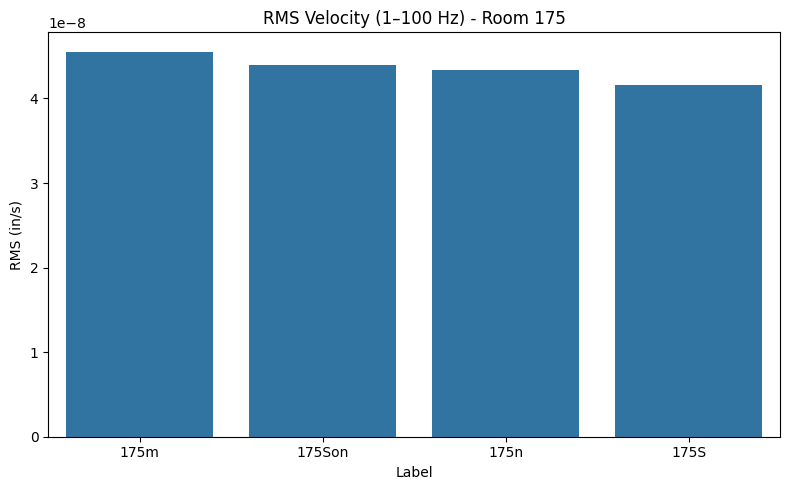

In [11]:
# BAR CHART - RMS (1–100 Hz)
def compute_band_rms(series, freqs, band=(1, 100)):
    mask = (freqs >= band[0]) & (freqs <= band[1])
    return np.sqrt((series[mask]**2).mean())

rms_results = []
for label in files.keys():
    rms = compute_band_rms(merged_df[label], merged_df["Hz"])
    rms_results.append((label, rms))

rms_df = pd.DataFrame(rms_results, columns=["Label", "RMS (in/s)"])

plt.figure(figsize=(8, 5))
sns.barplot(data=rms_df.sort_values("RMS (in/s)", ascending=False), x="Label", y="RMS (in/s)")
plt.title("RMS Velocity (1–100 Hz) - Room 175")
plt.tight_layout()
plt.show()

In [12]:
# FIXED SPIDER CHART - VALUE AT 20 Hz
target_freq = 20
idx = (merged_df["Hz"] - target_freq).abs().idxmin()
values = [merged_df.loc[idx, label] for label in files.keys()]
labels = list(files.keys())

In [13]:
# Close the loop
values.append(values[0])
labels.append(labels[0])
angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False).tolist()

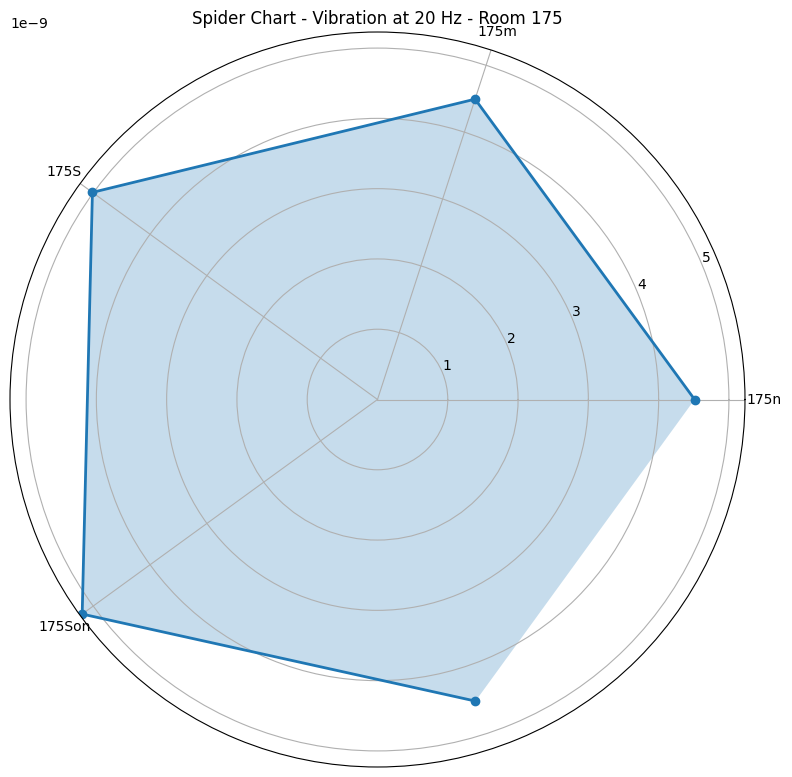

In [14]:
# Plot spider chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels[:-1])
ax.set_title(f"Spider Chart - Vibration at {target_freq} Hz - Room 175")
plt.tight_layout()
plt.show()

In [15]:
merged_df

,Hz,175n,175m,175S,175Son
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.5,2.727665e-05,2.959346e-05,2.449566e-05,2.652887e-05
2,1.0,5.059779e-07,5.397179e-07,4.704304e-07,5.137021e-07
3,1.5,2.312501e-07,2.552553e-07,2.426018e-07,2.304915e-07
4,2.0,1.644698e-07,1.429519e-07,1.656466e-07,1.591856e-07
...,...,...,...,...,...
796,398.0,8.782310e-11,7.630160e-11,7.702992e-11,6.979418e-11
797,398.5,7.457772e-11,8.057801e-11,7.620814e-11,7.971275e-11
798,399.0,7.669373e-11,7.676563e-11,8.603252e-11,7.629906e-11
799,399.5,8.083953e-11,8.212844e-11,8.086865e-11,7.266675e-11


In [16]:
mean_values = merged_df.drop(columns="Hz").mean()

# Print mean of each direction
print(" Mean vibration velocity for each direction:")
print(mean_values)

# Print overall mean across all directions
overall_mean = mean_values.mean()
print("\n Overall mean vibration velocity across all directions:")
print(overall_mean)


 Mean vibration velocity for each direction:
175n      3.654999e-08
175m      3.947861e-08
175S      3.306806e-08
175Son    3.565986e-08
dtype: float64

 Overall mean vibration velocity across all directions:
3.6189130391370166e-08


In [18]:
merged_df.to_csv("Room113_MergedVibrationData.csv", index=False)